In [1]:
import os
import time
import spacy
import string
import numpy as np
import itertools
import pickle as pkl
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from alibi.explainers import AnchorText
from alibi.datasets import fetch_movie_sentiment
from alibi.utils.download import spacy_model
from alibi.utils.lang_model import DistilbertBaseUncased, BertBaseUncased, RobertaBase

%load_ext autoreload
%autoreload 2

/home/robert/anaconda3/envs/alibi/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


### Load movie review dataset

The `fetch_movie_sentiment` function returns a `Bunch` object containing the features, the targets and the target names for the dataset.

In [2]:
movies = fetch_movie_sentiment()
movies.keys()

dict_keys(['data', 'target', 'target_names'])

In [3]:
data = movies.data
labels = movies.target
target_names = movies.target_names

In [4]:
train, test, train_labels, test_labels = train_test_split(data, labels, test_size=.2, random_state=42)
train, val, train_labels, val_labels = train_test_split(train, train_labels, test_size=.1, random_state=42)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

### Apply CountVectorizer to training set

In [5]:
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(train)

CountVectorizer()

### Fit model

In [6]:
np.random.seed(0)
clf = LogisticRegression(solver='liblinear')
clf.fit(vectorizer.transform(train), train_labels)

LogisticRegression(solver='liblinear')

### Define prediction function

In [7]:
predict_fn = lambda x: clf.predict(vectorizer.transform(x))

### Make predictions on train and test sets

In [8]:
preds_train = predict_fn(train)
preds_val = predict_fn(val)
preds_test = predict_fn(test)
print('Train accuracy', accuracy_score(train_labels, preds_train))
print('Validation accuracy', accuracy_score(val_labels, preds_val))
print('Test accuracy', accuracy_score(test_labels, preds_test))

Train accuracy 0.9801624284382905
Validation accuracy 0.7544910179640718
Test accuracy 0.7589841878294202


### Load spaCy model

English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS tags, dependency parse and named entities.

In [9]:
model = 'en_core_web_md'
spacy_model(model=model)
nlp = spacy.load(model)

### Load transformers

In [10]:
lang_model = DistilbertBaseUncased()

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Random indices

In [11]:
indices = np.random.choice(len(test), size=10, replace=False)
print(indices)

[ 299  379  997 1601  264  229 1774 1968  458  252]


### Define Anchor

In [12]:
explainer = AnchorText(nlp=nlp, language_model=lang_model, predictor=predict_fn)

In [13]:
def build_explanation(explanation) -> str:
    s = ''
    s += 'Anchor: %s\n' % (' AND '.join(explanation.anchor))
    s += 'Precision: %.2f\n' % explanation.precision
    
    # print examples covered as True
    s += '\n\nExamples where anchor applies and model predicts %s:\n' % pred
    if len(explanation.raw['examples']):
        s += '\n'.join([x for x in explanation.raw['examples'][-1]['covered_true']])
    
    # print examples covered as False
    s += '\n\nExamples where anchor applies and model predicts %s:\n' % alternative
    if len(explanation.raw['examples']):
        s += '\n'.join([x for x in explanation.raw['examples'][-1]['covered_false']])
    
    s += '\n\n\n'
    return s

In [14]:
config_similarity = {
    "threshold": [0.95],
    "sample_proba": [0.5],
    "punctuation": [string.punctuation],
    "top_n": [10, 100, 500],
    "sampling_method": ["similarity"]
}

config_language_model = {
    "threshold": [0.95],
    "sample_proba": [0.5],
    "filling_method": ['parallel'],
    "punctuation": [string.punctuation],
    "top_n": [10, 100, 500],
    "prec_mask_templates": [0.1, 0.5, 1.0],
    "sampling_method": ["language_model"]
}


In [15]:
class_names = movies.target_names

### Benchmarking

In [21]:
def run_configuration(tests: dict, file_name: str) -> dict:
    # get all combinations
    values = tests.values()
    combinations = itertools.product(*values)
    
    # open checkpoint file
    f = open(file_name, 'wb')
    configs = []

    for comb in tqdm(combinations):
        # build configuration
        config = dict(zip(tests.keys(), comb))
        config['elapsed_time'] = 0

        for index in tqdm(indices):
            text = test[index]

            # compute text prediction
            pred = class_names[predict_fn([text])[0]]
            alternative = class_names[1 - predict_fn([text])[0]]
         
            # define explainer
            np.random.seed(0)
            explainer = AnchorText(nlp=nlp, language_model=lang_model, predictor=predict_fn)

            # compute explanation
            start = time.time()
            explanation = explainer.explain(text, **config)
            config['elapsed_time'] += (time.time() - start)
        
        # compute mean
        config['elapsed_time'] /= len(indices)
        configs.append(config)
        
    # append it to output file
    pkl.dump(configs, f)
    f.close()
    
    return configs


In [22]:
if not os.path.exists("stats_similarity.pkl"):
    configs_sim = run_configuration(config_similarity, "stats_similarity.pkl")

with open("stats_similarity.pkl", "rb") as fin:
    configs_sim = pkl.load(fin)

In [ ]:
if not os.path.exists("stats_lm.pkl"):
    configs_lm = run_configuration(config_language_model, "stats_lm.pkl")

with open("stats_lm.pkl", "rb") as fin:
    configs_lm = pkl.load(fin)

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:43<00:00,  4.39s/it]
1it [00:43, 43.94s/it]
100%|██████████| 10/10 [03:53<00:00, 23.32s/it]
2it [04:37, 155.29s/it]
100%|██████████| 10/10 [07:28<00:00, 44.85s/it]
3it [12:05, 289.19s/it]
100%|██████████| 10/10 [00:51<00:00,  5.17s/it]
4it [12:57, 195.42s/it]
 60%|██████    | 6/10 [02:38<01:31, 22.99s/it]

In [19]:
x, y = [], []

# collect similarity results
for conf in configs_sim:
    name = "%s, top %d" % ("SIM", conf["top_n"])
    x.append(name)
    y.append(conf["elapsed_time"])

# collect language model results
for conf in configs_lm:
    name = "%s, top %d, PMT %.2f" % \
        ("LM", conf["top_n"], conf["prec_mask_templates"])
    x.append(name)
    y.append(conf["elapsed_time"])

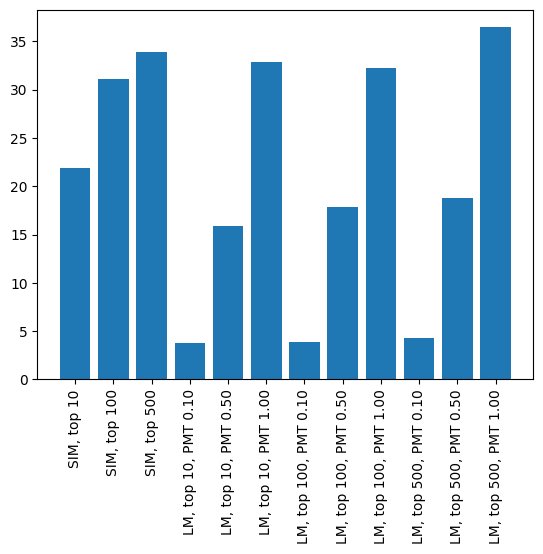

In [20]:
import matplotlib.pyplot as plt

plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.xticks(rotation=90)
plt.show()